In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
import functools
import tensorflow_hub as hub
import matplotlib as mpl
from PIL import Image
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [28]:
!wget https://raw.githubusercontent.com/jcjohnson/fast-neural-style/master/images/content/chicago.jpg
!wget https://raw.githubusercontent.com/jcjohnson/fast-neural-style/master/images/styles/la_muse.jpg
!wget https://raw.githubusercontent.com/jcjohnson/fast-neural-style/master/images/styles/composition_vii.jpg
!wget https://upload.wikimedia.org/wikipedia/en/8/8f/Pablo_Picasso%2C_1909-10%2C_Figure_dans_un_Fauteuil_%28Seated_Nude%2C_Femme_nue_assise%29%2C_oil_on_canvas%2C_92.1_x_73_cm%2C_Tate_Modern%2C_London.jpg

--2020-01-27 23:46:48--  https://raw.githubusercontent.com/jcjohnson/fast-neural-style/master/images/content/chicago.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219977 (215K) [image/jpeg]
Saving to: ‘chicago.jpg.4’

chicago.jpg.4       100%[===================>] 214.82K  --.-KB/s    in 0.04s   

2020-01-27 23:46:48 (5.14 MB/s) - ‘chicago.jpg.4’ saved [219977/219977]

--2020-01-27 23:46:53--  https://raw.githubusercontent.com/jcjohnson/fast-neural-style/master/images/styles/la_muse.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [0]:
##define a funct. to load image & limit its max. dim. to 512 pxls
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

##A simple function to display an image:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  if title:
    plt.title(title)

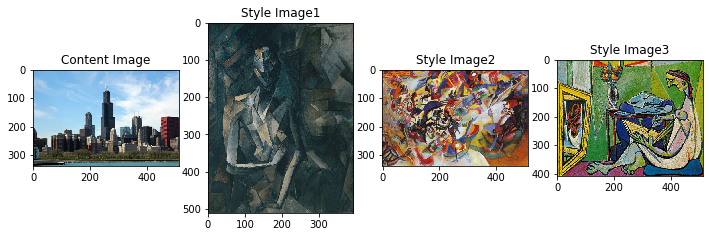

In [29]:
##Image1
content_image = load_img('chicago.jpg')
style_image1 = load_img('Pablo_Picasso,_1909-10,_Figure_dans_un_Fauteuil_(Seated_Nude,_Femme_nue_assise),_oil_on_canvas,_92.1_x_73_cm,_Tate_Modern,_London.jpg')
style_image2 = load_img('composition_vii.jpg')
style_image3 = load_img('la_muse.jpg')
plt.subplot(1, 4, 1)
imshow(content_image1, 'Content Image')
plt.subplot(1, 4, 2)
imshow(style_image1, 'Style Image1')
plt.subplot(1, 4, 3)
imshow(style_image2, 'Style Image2')
plt.subplot(1, 4, 4)
imshow(style_image3, 'Style Image3')

In [30]:
##Define content and style representations
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

##Now load a VGG19 without the classification head, and list the layer names
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_7
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
##Choose intermediate layers from the network to represent the style and content of the image:
## Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

## Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

##function that builds a VGG19 CNN model that returns a list of intermediate layer outputs:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

##to create the model:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image1*255)

In [32]:
##Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 393, 64)
  min:  0.0
  max:  714.55396
  mean:  12.87384

block2_conv1
  shape:  (1, 256, 196, 128)
  min:  0.0
  max:  3066.083
  mean:  78.88549

block3_conv1
  shape:  (1, 128, 98, 256)
  min:  0.0
  max:  4891.4287
  mean:  74.117874

block4_conv1
  shape:  (1, 64, 49, 512)
  min:  0.0
  max:  9008.776
  mean:  334.44025

block5_conv1
  shape:  (1, 32, 24, 512)
  min:  0.0
  max:  1807.9724
  mean:  24.943062



In [0]:
##calculate style using gram matrix
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [0]:
##Build a model that returns the style and content tensors.
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [35]:
##When called on an image, this model returns the gram matrix (style) of the style_layers and content of the
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))
style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.02742087
    max:  55979.023
    mean:  699.47766

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  91163.516
    mean:  16390.59

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  354304.72
    mean:  15713.154

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4512012.0
    mean:  232466.42

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  159752.53
    mean:  2205.247

Contents:
   block5_conv2
    shape:  (1, 21, 32, 512)
    min:  0.0
    max:  1291.308
    mean:  15.6846695


In [0]:
##Run gradient descent
style_targets = extractor(style_image1)['style']
content_targets = extractor(content_image)['content']

#Defining a tf.Variable to contain the image to optimize.
image = tf.Variable(content_image)

##define a function to keep the pixel values between 0 and 1 as it is a float image
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

##creatng an optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

##to optimize, we use a weighted combination of the two losses to get the total loss:
style_weight=1e-2
content_weight=1e4


In [0]:
##calculate loss
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [0]:
##update the image with loss
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

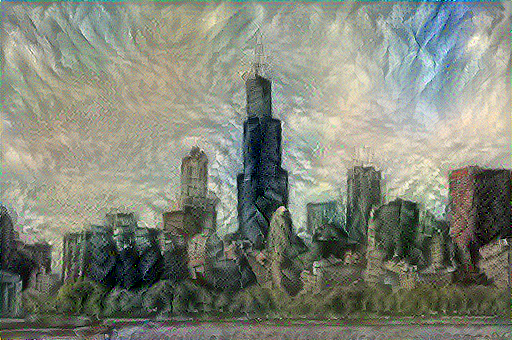

Train step: 300
................................................................................................

In [0]:
##performing longer optimization
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))